# Various ways to inspect observed data

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import katdal

In [3]:
filename='data/1548939342_sdp_l0.full.rdb'
data = katdal.open(filename, applycal=['K','B','G'])
print data

/usr/local/lib/python2.7/dist-packages/katsdptelstate/telescope_state.py:338: FutureWarning: The telescope state contains pickled values. This is a security risk, but is allowed because MeerKAT data up to March 2019 uses it. You can suppress this warning by setting KATSDPTELSTATE_ALLOW_PICKLE=1 in the environment, or disable pickles by setting KATSDPTELSTATE_ALLOW_PICKLE=0.
  warnings.warn(PICKLE_WARNING, FutureWarning)


Name: file:///data/1548939342_sdp_l0.full.rdb | 1548939342-sdp-l0 (version 4.0)
Observer: Lindsay  Experiment ID: 20190131-0012
Description: '[don't clone] MKAIV-449 Three calibrator Imaging (long track)'
Observed from 2019-01-31 14:56:12.123 SAST to 2019-01-31 14:59:48.031 SAST
Dump rate / period: 0.12505 Hz / 7.997 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m001,m002,m003,m004,m005,m009,m010,m011,m013,m014,m015,m017,m019,m020,m021,m022,m023,m024,m025,m027,m028,m029,m031,m032,m033,m035,m037,m038,m039,m040,m041,m042,m043,m044,m045,m046,m047,m048,m049,m050,m051,m055,m056,m057,m058,m059,m060,m061,m062  100      5100
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    bc856M1k   1284.000         856.000           1024       835.938
-------------------------------------------------------------------------------
Data selected according to the following criteria:
  ants=['m000', 'm001', 'm002

The very useful `data` handle can be used to explore the data without directly .... large data sets that takes for ever the be written to disk or to be read from disk.
Also, some systems may not be able to handle interaction with these very large data `files` 
You need to explore the data beforehand and decide what you need to process and go about it systematically

## MeerKAT L-band passband
The most common bad data are probably malfunctioning antennas and channels corrupted by RFI.

![lbandpb](images/MKAT_L-band.png)

| RFI Source | Frequency Range (MHz) |
| --- | --- |
| GSM (Mobile Phones) | 900-915 MHz uplink |
|| 925-960 MHz downlink
| Aircraft Transponders | Multiple $<$ 1MHz bandwidth intermittent signals between 1000 and 1200 MHz
| GPS | L1: 1565-1585 |
|| L2: 1217-1237 |
|| L3: 1375-1387 |
|| L5: 1166-1186 |
| GLONASS | L1: 1592-1610 |
|| L2: 1242-1249 |
| Galileo |1191-1217, 1260-1300 |
| Afristar |1453-1490 |
| IRIDIUM | 1616-1626 |
| Inmarsat | 1526-1554 |
| Alkantpan | 1600 |

### Utility functions for getting MeerKAT channel number to frequency mappings

In [4]:
def freq2chan(frequency, bandwidth, n_chans):
    channel_nr = round(float(frequency)/float(bandwidth)*n_chans)%n_chans
    return int(channel_nr)

In [5]:
def chan2bbfreq(channel_nr, bandwidth, n_chans):
    frequency = round(float(channel_nr)/float(n_chans)*float(bandwidth))%bandwidth
    return frequency

In [6]:
def chan2freq(channel_nr, bandwidth, channel_freqs):
    frequency = chan2bbfreq(channel_nr, bandwidth, len(channel_freqs))
    c_width = np.mean(np.diff(channel_freqs))
    return channel_freqs[0] + frequency - c_width/2.

For reference, the frequency band $1326.21\,MHz$ to $1368.01\,MHz$ is clean for MeerKAT and a good location for initial inspection and calculation.

In [7]:
# subset of channels that are known to be relative RFI free (close and around 1.4GHz)
f_low = 1326214844.0
f_high = 1368011719.0
# get MeerKAT channels for frequency range
bandwidth = data.channel_width*len(data.channels)
n_chans = len(data.channels)
c_low = freq2chan(f_low, bandwidth, n_chans)
c_high = freq2chan(f_high, bandwidth, n_chans)

print('Frequency range {:.3f}-{:.3f} MHz maps to channels {}-{}'.format(
    f_low/1e6, f_high/1e6, c_low, c_high))
print('{} channels over bandpass, maps to {:.3f}-{:.3f} MHz'.format(
    n_chans,
    chan2freq(c_low, bandwidth, data.channel_freqs)/1e6,
    chan2freq(c_high, bandwidth, data.channel_freqs)/1e6))

Frequency range 1326.215-1368.012 MHz maps to channels 563-613
1024 channels over bandpass, maps to 1326.215-1368.012 MHz


In [8]:
# select target of interest
target = 'PKS 1934-63'

# subset of channels that are known to be relative RFI free (around 1.4GHz)
chan_slice = slice(c_low, c_high)

0 H


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1 V
20.7187700272


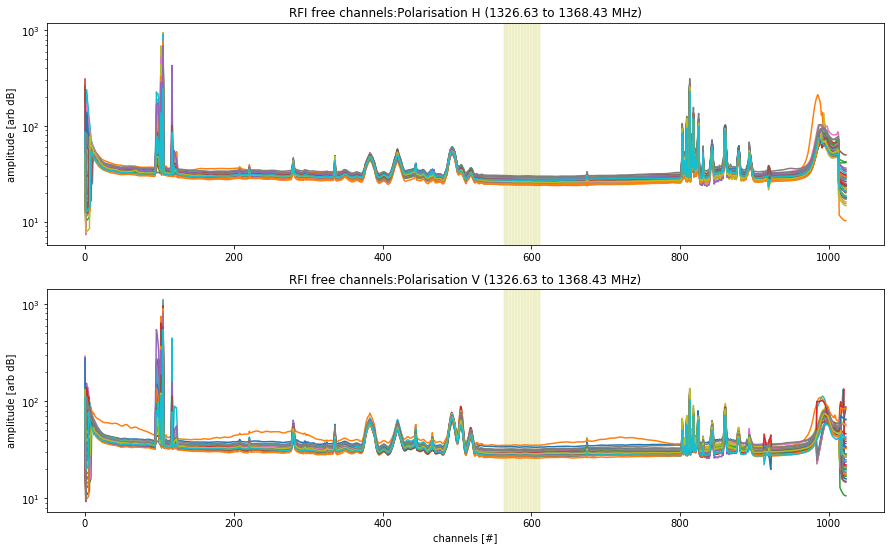

In [9]:
import time
stime = time.time()
plt.figure(figsize=[15,9])
for idx, pol in enumerate(['H', 'V']):
    print idx, pol
    data.select()
    data.select(targets=target, pol=pol, scans='track', corrprods='auto')
    bandpass = data.vis.dataset.mean(axis=0).compute()
    plt.subplot(2, 1, idx+1)
    for chan in data.channels[chan_slice]:
        plt.axvline(x=data.channels[chan], color='y', alpha=0.1)
    plt.semilogy(data.channels, bandpass)
    plt.axis('tight')
    plt.title('RFI free channels:Polarisation %s (%.2f to %.2f MHz)' % \
             (pol, data.channel_freqs[chan_slice.start]/1e6, data.channel_freqs[chan_slice.stop]/1e6))
    plt.ylabel('amplitude [arb dB]')
plt.xlabel('channels [#]')
etime = time.time() - stime
print etime

Use flags to remove channels known to have RFI

Note: pre-flagging is generally only good to use for continuum imaging and not for spectral lines, since it will flag out the science lines.   
The most common bad data are probably malfunctioning antennas and channels corrupted by RFI.

Text(0.5,0,u'channels [#]')

/usr/local/lib/python2.7/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


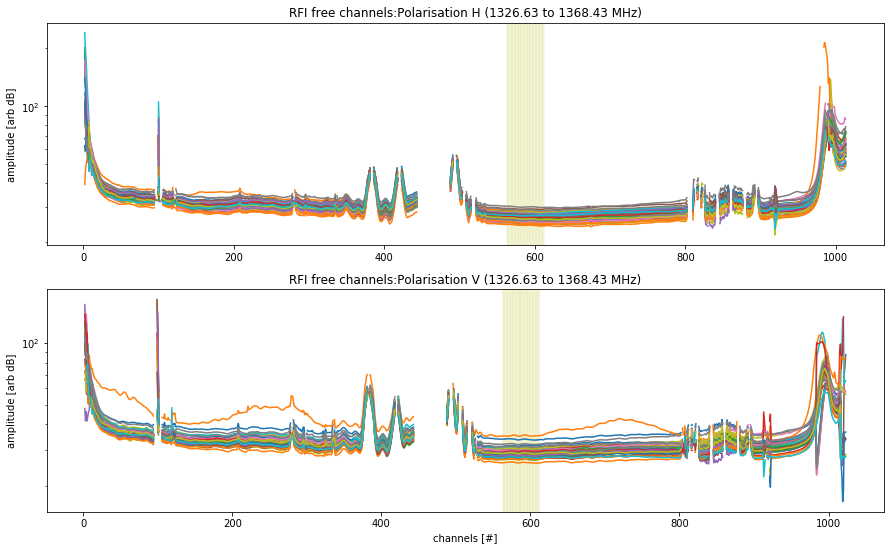

In [10]:
plt.figure(figsize=[15,9])
for idx, pol in enumerate(['H', 'V']):
    data.select()
    # select all tracks on all targets, for ref_ant single pol auto-corr
    data.select(targets=target, pol=pol, scans='track', corrprods='auto')

    visibilities=np.abs(data.vis[:])
    flags=data.flags[:]
    visibilities[flags]=np.nan    
    bandpass = np.mean(visibilities, axis=0)
    
    plt.subplot(2,1,idx+1)
    for chan in data.channels[chan_slice]:
        plt.axvline(x=data.channels[chan], color='y', alpha=0.1)
    plt.semilogy(data.channels, bandpass)
    plt.axis('tight')
    plt.title('RFI free channels:Polarisation %s (%.2f to %.2f MHz)' % \
             (pol, data.channel_freqs[chan_slice.start]/1e6, data.channel_freqs[chan_slice.stop]/1e6))
    plt.ylabel('amplitude [arb dB]')
plt.xlabel('channels [#]')

### Inspect antennas
For point-like sources the uncalibrated visibility amplitude on all baselines should be approximately the same, and the uncalibrated visibility phases should be fairly stable, although not necessarily close to 0 deg.   
Thus plot amplitude for all baseline together, investigate any outlier baselines to identify possible bad antenna data.

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


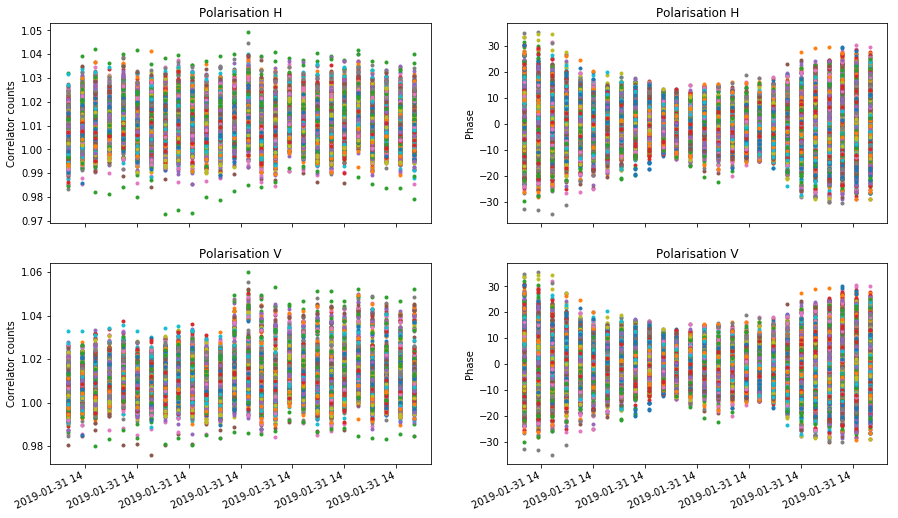

In [11]:
import datetime
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 2, figsize=[15,9], sharex=True)
date_fmt = "%Y-%m-%d %H"
date_formatter = mdates.DateFormatter(date_fmt)

for idx, pol in enumerate(['H', 'V']):
    data.select()
    data.select(targets=target, pol=pol, scans='track', corrprods='cross')
    visibilities=data.vis[:]
    flags=data.flags[:]
    visibilities[flags]=np.nan 
    timeseries = np.nanmean(np.abs(visibilities), axis=1)
    mymean= np.mean(timeseries, axis=0)
    phase = np.nanmean(np.angle(visibilities, deg=True), axis=1)
    datetimes = [datetime.datetime.fromtimestamp(unix_timestamp) for unix_timestamp in data.timestamps]
    axes[idx, 0].plot_date(datetimes, timeseries, '.')
    axes[idx, 0].set_ylabel('Correlator counts')
    axes[idx, 0].set_title('Polarisation %s' % pol)
    axes[idx, 1].plot_date(datetimes, phase, '.')
    axes[idx, 1].set_ylabel('Phase')
    axes[idx, 1].set_title('Polarisation %s' % pol)
    axes[1,1].xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate(rotation=25)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


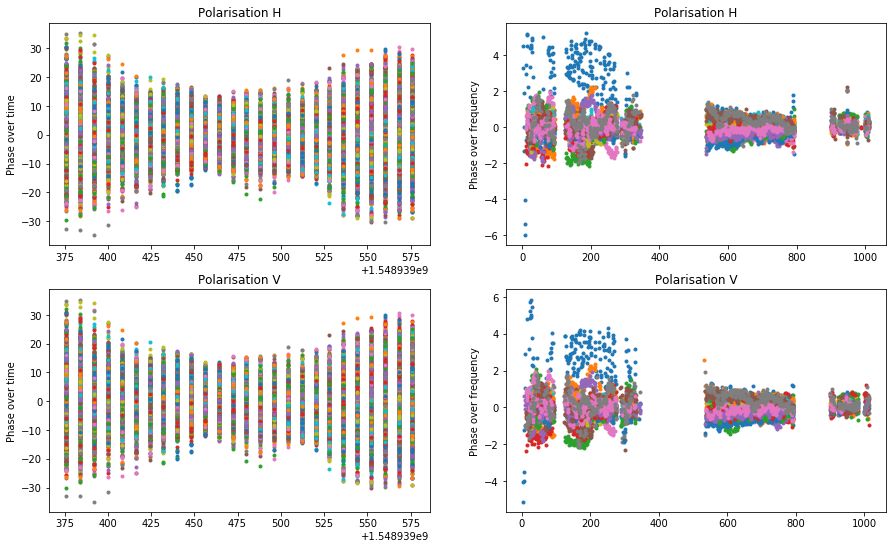

In [13]:
plt.figure(figsize=[15, 9])
for idx, pol in enumerate(['H', 'V']):
    data.select()
    data.select(targets=target, pol=pol, scans='track', corrprods='cross')
    visibilities=data.vis[:]
    flags=data.flags[:]
    visibilities[flags]=np.nan 
    phase = np.angle(visibilities, deg=True)
    timephase = np.nanmean(phase, axis=1)
    freqphase = np.mean(phase, axis=0)
    
    plt.subplot(2, 2, 2*idx+1)
    plt.plot(data.timestamps, timephase, '.')
    plt.ylabel('Phase over time')
    plt.title('Polarisation %s' % pol)
    plt.subplot(2, 2, 2*(idx+1))
    plt.plot(data.channels, freqphase[:,::70], '.')
    plt.ylabel('Phase over frequency')
    plt.title('Polarisation %s' % pol)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


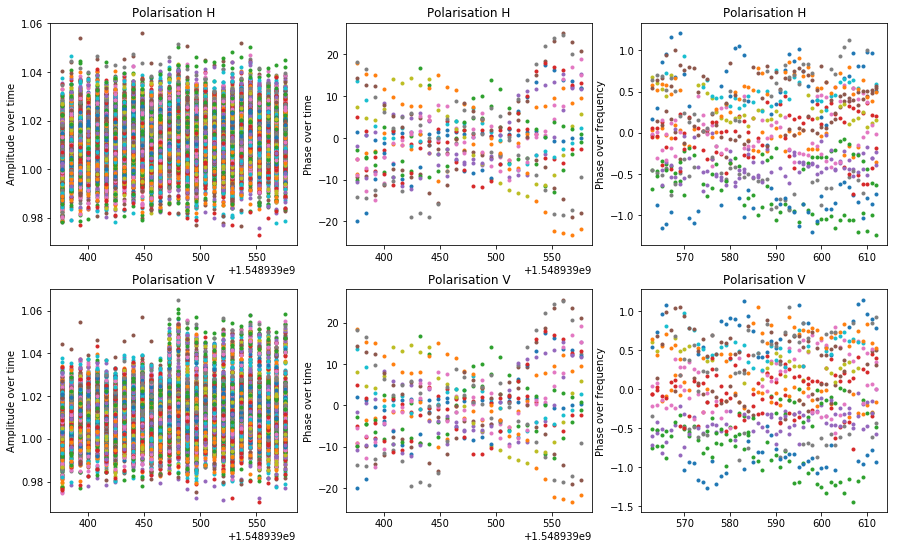

In [14]:
plt.figure(figsize=[15,9])
for idx, pol in enumerate(['H', 'V']):
    data.select()
    data.select(targets=target, pol=pol, scans='track', corrprods='cross', channels=chan_slice)
    visibilities=data.vis[:]
    flags=data.flags[:]
    visibilities[flags]=np.nan 
    phase = np.angle(visibilities, deg=True)
    timeseries = np.nanmean(np.abs(visibilities), axis=1)
    timephase = np.nanmean(phase, axis=1)
    freqphase = np.mean(phase, axis=0)
    
    plt.subplot(2,3,3*idx+1)
    plt.plot(data.timestamps, timeseries, '.')
    plt.ylabel('Amplitude over time')
    plt.title('Polarisation %s' % pol)
    plt.subplot(2,3,3*idx+2)
    plt.plot(data.timestamps, timephase[:,::70], '.')
    plt.ylabel('Phase over time')
    plt.title('Polarisation %s' % pol)
    plt.subplot(2,3,3*(idx+1))
    plt.plot(data.channels, freqphase[:,::70], '.')
    plt.ylabel('Phase over frequency')
    plt.title('Polarisation %s' % pol)

## Waterfall plots
### Cross Correlation

In [15]:
data.select()
data.select(corrprods='cross',pol='H')

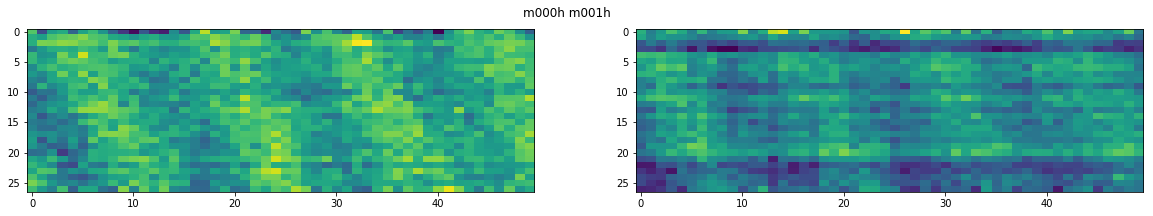

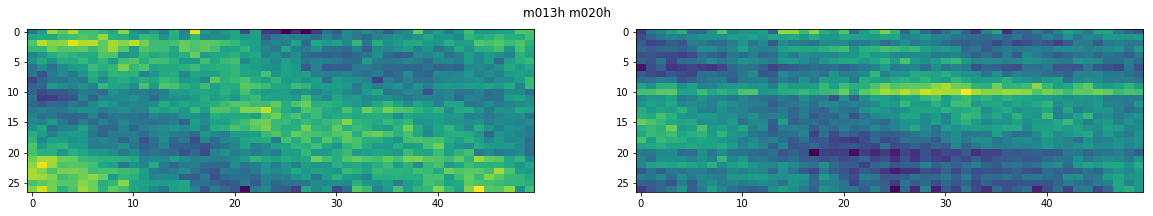

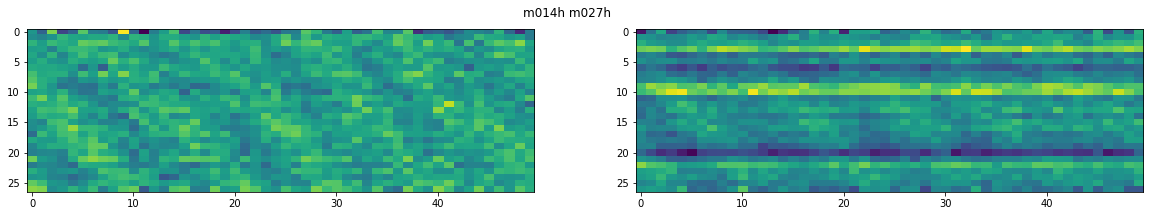

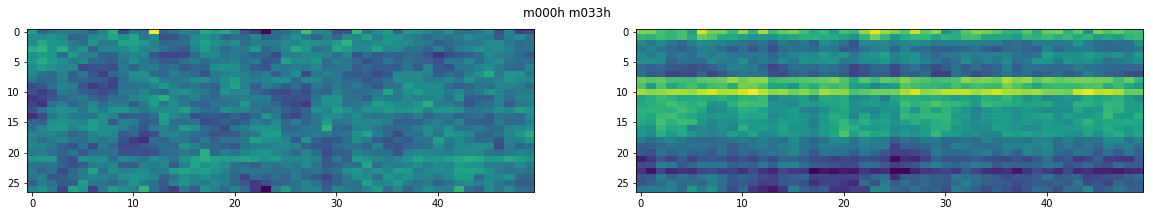

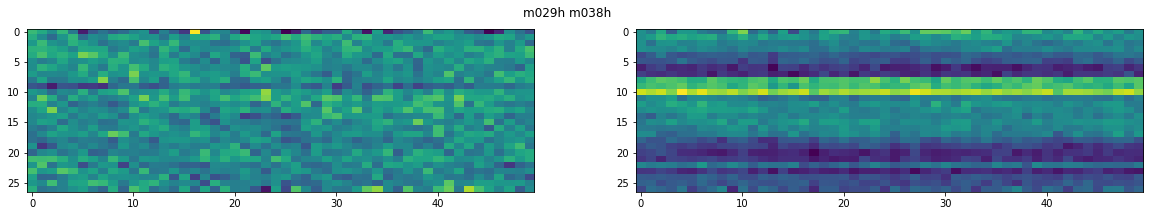

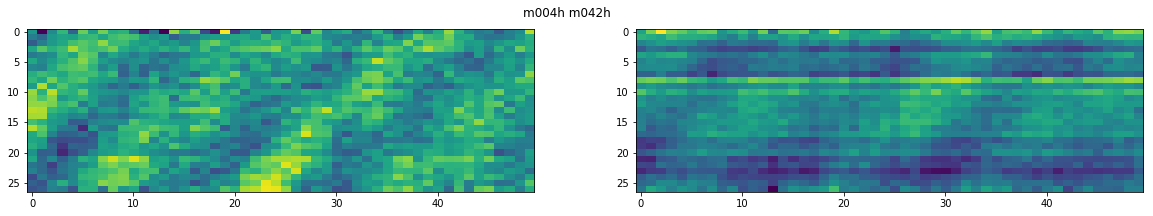

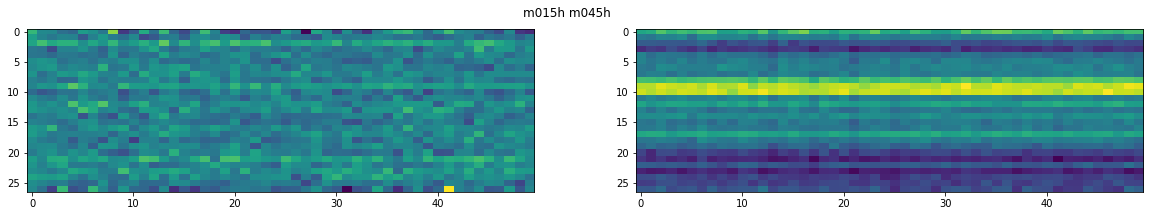

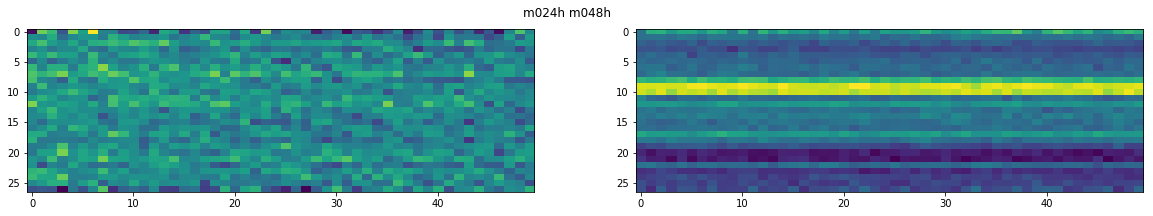

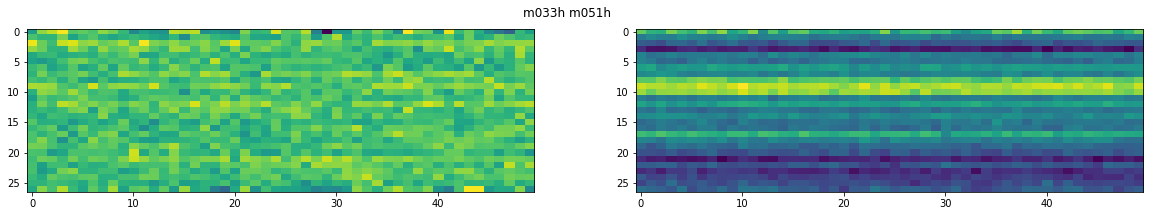

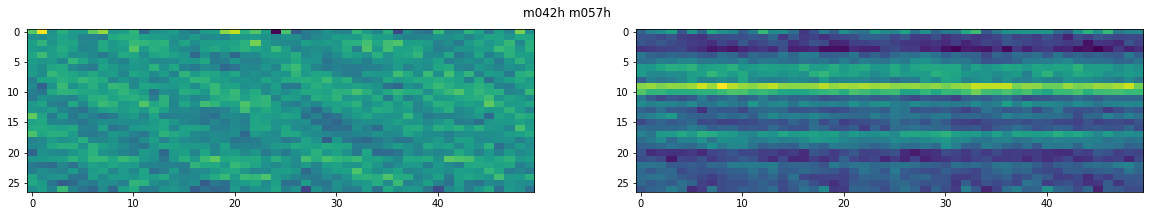

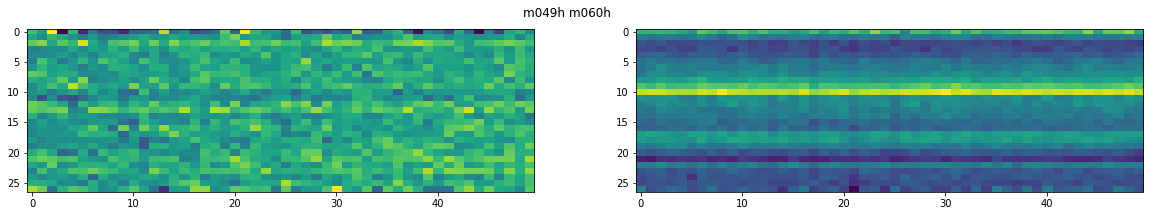

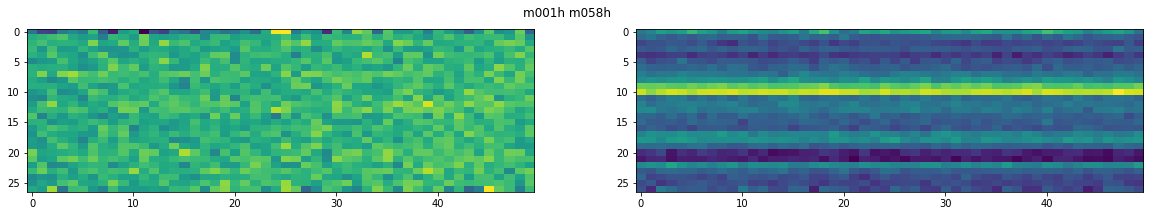

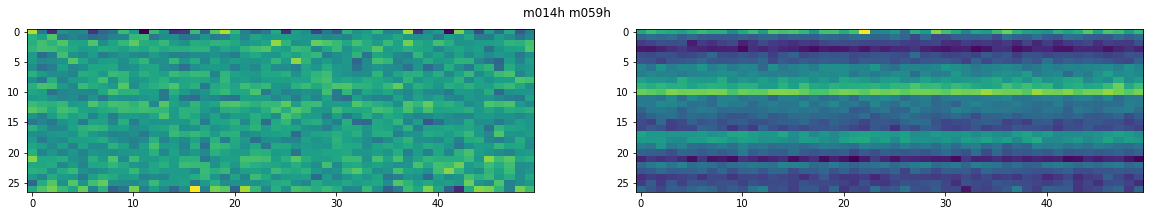

In [16]:
for i,p in enumerate(data.corr_products[::100]):
    v = np.squeeze(data.vis[:, chan_slice, i])

    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    fig.suptitle(p[0]+' '+p[1])
    ax[0].imshow(np.abs(v), aspect='auto')
    ax[1].imshow(np.angle(v), aspect='auto')   